In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-05-31 20:50:44--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  8.37MB/s    in 6m 49s  

2024-05-31 20:57:35 (3.23 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


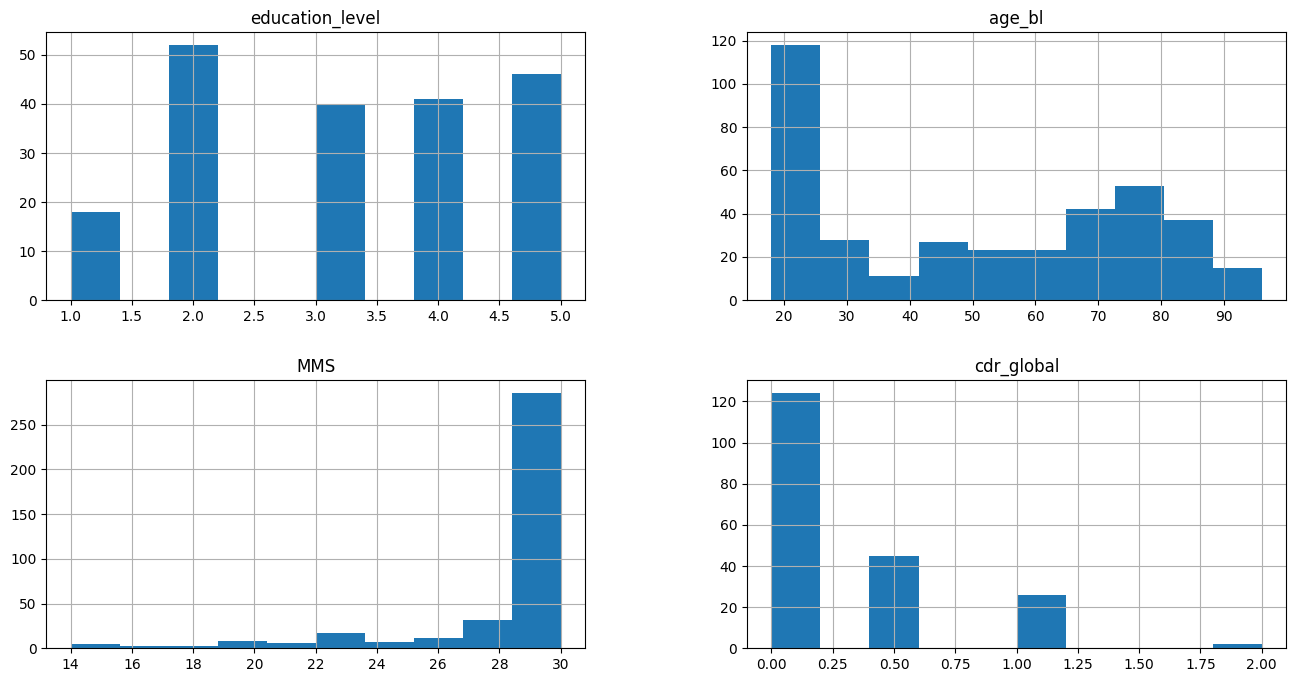

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:
class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.BatchNorm3d(current_channels),
                nn.ReLU(inplace=True),
                nn.Conv3d(current_channels, growth_rate, kernel_size=3, padding=1, bias=False),
                nn.Dropout3d(0.2)
            )
            self.layers.append(layer)
            current_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat([x, new_features], 1)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.downsample = nn.Sequential(
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.AvgPool3d(2, stride=2)
        )

    def forward(self, x):
        return self.downsample(x)

class DenseNet3D(nn.Module):
    def __init__(self):
        super(DenseNet3D, self).__init__()
        growth_rate = 16
        num_blocks = [6, 12, 24, 16]  # Example configuration of layers in each block
        num_init_features = 16
        compression_factor = 0.5

        self.initial_conv = nn.Conv3d(1, num_init_features, kernel_size=3, padding=1)

        # Dense blocks and transition layers
        num_features = num_init_features
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(num_blocks):
            block = DenseBlock(num_layers, num_features, growth_rate)
            self.blocks.append(block)
            num_features += num_layers * growth_rate

            if i != len(num_blocks) - 1:
                out_features = int(num_features * compression_factor)
                transition = TransitionLayer(num_features, out_features)
                self.blocks.append(transition)
                num_features = out_features

        # Final batch normalization and classifier
        self.final_bn = nn.BatchNorm3d(num_features)
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Linear(num_features, 2)

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = F.relu(self.final_bn(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.0896, Val loss = 9.8236
Epoch 1: Train loss = 1.8328, Val loss = 9.4253
Epoch 2: Train loss = 1.7582, Val loss = 8.5400
Epoch 3: Train loss = 1.5892, Val loss = 8.1868
Epoch 4: Train loss = 1.5241, Val loss = 8.0506
Epoch 5: Train loss = 1.5037, Val loss = 12.0723
Epoch 6: Train loss = 1.4304, Val loss = 8.2598
Epoch 7: Train loss = 1.4442, Val loss = 9.8791
Epoch 8: Train loss = 1.3051, Val loss = 10.8923
Epoch 9: Train loss = 1.6866, Val loss = 7.8916
Epoch 10: Train loss = 1.4052, Val loss = 7.8673
Epoch 11: Train loss = 1.4935, Val loss = 7.7121
Epoch 12: Train loss = 1.1757, Val loss = 9.0272
Epoch 13: Train loss = 1.3326, Val loss = 8.0266
Epoch 14: Train loss = 1.3212, Val loss = 7.8583


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[60  2]
 [ 6  9]]


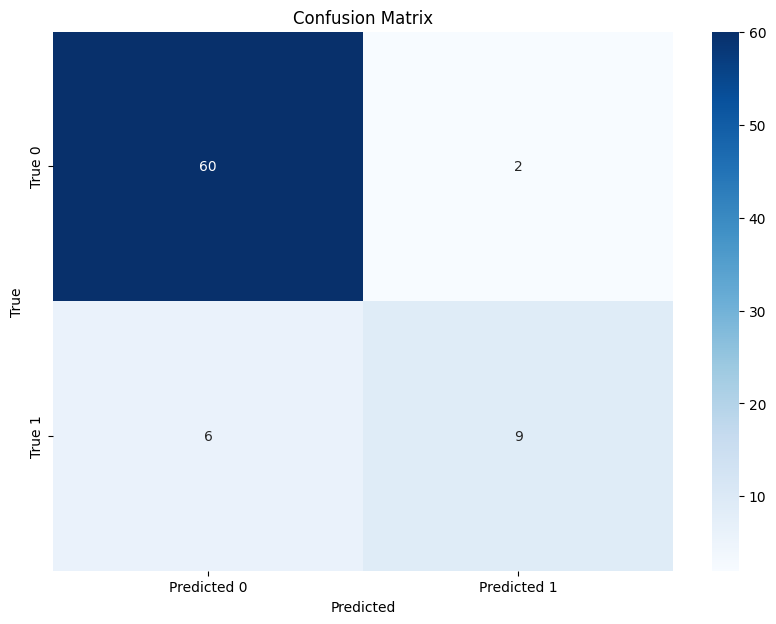

Learning Rate: 0.001 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.9941, Val loss = 8.4419
Epoch 1: Train loss = 1.7622, Val loss = 8.8993
Epoch 2: Train loss = 1.4980, Val loss = 8.2070
Epoch 3: Train loss = 1.5910, Val loss = 9.7530
Epoch 4: Train loss = 1.4991, Val loss = 8.9152
Epoch 5: Train loss = 1.4551, Val loss = 9.0459
Epoch 6: Train loss = 1.4081, Val loss = 8.1067
Epoch 7: Train loss = 1.3414, Val loss = 7.9489
Epoch 8: Train loss = 1.4503, Val loss = 9.7859
Epoch 9: Train loss = 1.3753, Val loss = 8.7499
Epoch 10: Train loss = 1.4191, Val loss = 7.8502
Epoch 11: Train loss = 1.2942, Val loss = 7.8257
Epoch 12: Train loss = 1.3159, Val loss = 7.7243
Epoch 13: Train loss = 1.3940, Val loss = 7.4346
Epoch 14: Train loss = 1.2314, Val loss = 10.0783


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 6  9]]


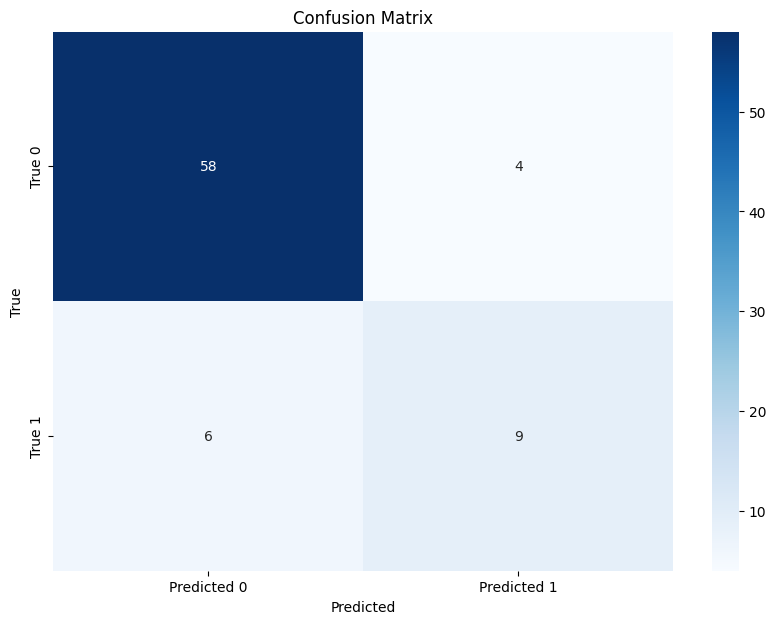

Learning Rate: 0.0005 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.0523, Val loss = 10.5000
Epoch 1: Train loss = 1.7154, Val loss = 9.6090
Epoch 2: Train loss = 1.7019, Val loss = 12.3770
Epoch 3: Train loss = 1.6996, Val loss = 8.1332
Epoch 4: Train loss = 1.5811, Val loss = 8.4903
Epoch 5: Train loss = 1.5199, Val loss = 8.0568
Epoch 6: Train loss = 1.4424, Val loss = 8.6668
Epoch 7: Train loss = 1.4779, Val loss = 7.5894
Epoch 8: Train loss = 1.3782, Val loss = 7.7573
Epoch 9: Train loss = 1.3839, Val loss = 8.3293
Epoch 10: Train loss = 1.3130, Val loss = 9.1210
Epoch 11: Train loss = 1.2127, Val loss = 8.7731
Epoch 12: Train loss = 1.2484, Val loss = 10.3639
Epoch 13: Train loss = 1.1738, Val loss = 9.0869
Epoch 14: Train loss = 1.3040, Val loss = 10.7147


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[57  5]
 [ 5 10]]


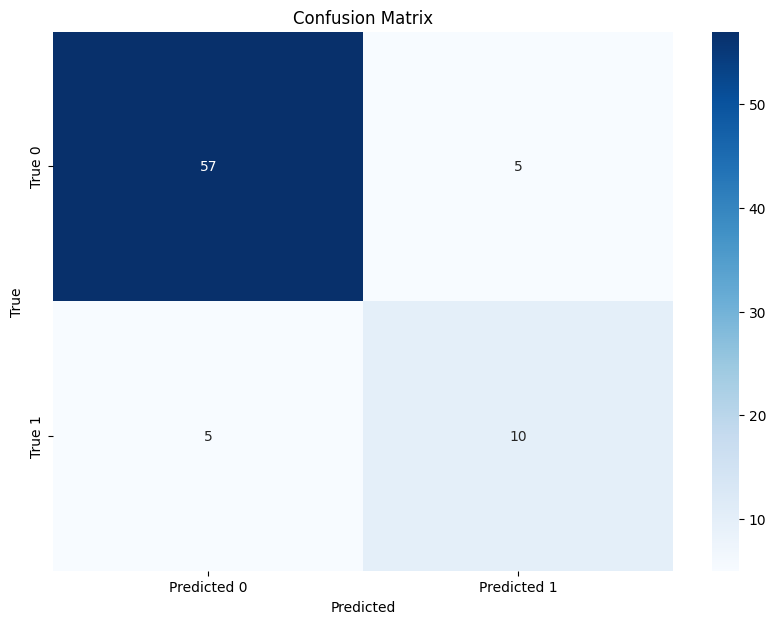

Learning Rate: 0.0001 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.5515, Val loss = 14.4789
Epoch 1: Train loss = 1.9841, Val loss = 11.6602
Epoch 2: Train loss = 1.8629, Val loss = 10.4603
Epoch 3: Train loss = 1.7518, Val loss = 8.8883
Epoch 4: Train loss = 1.6007, Val loss = 8.0100
Epoch 5: Train loss = 1.4404, Val loss = 8.0960
Epoch 6: Train loss = 1.5642, Val loss = 8.0709
Epoch 7: Train loss = 1.5060, Val loss = 7.6060
Epoch 8: Train loss = 1.3408, Val loss = 10.5297
Epoch 9: Train loss = 1.5286, Val loss = 8.1917
Epoch 10: Train loss = 1.3498, Val loss = 7.4456
Epoch 11: Train loss = 1.3728, Val loss = 8.2259
Epoch 12: Train loss = 1.2568, Val loss = 10.3886
Epoch 13: Train loss = 1.2164, Val loss = 7.5067
Epoch 14: Train loss = 1.2400, Val loss = 8.6726


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[57  5]
 [ 4 11]]


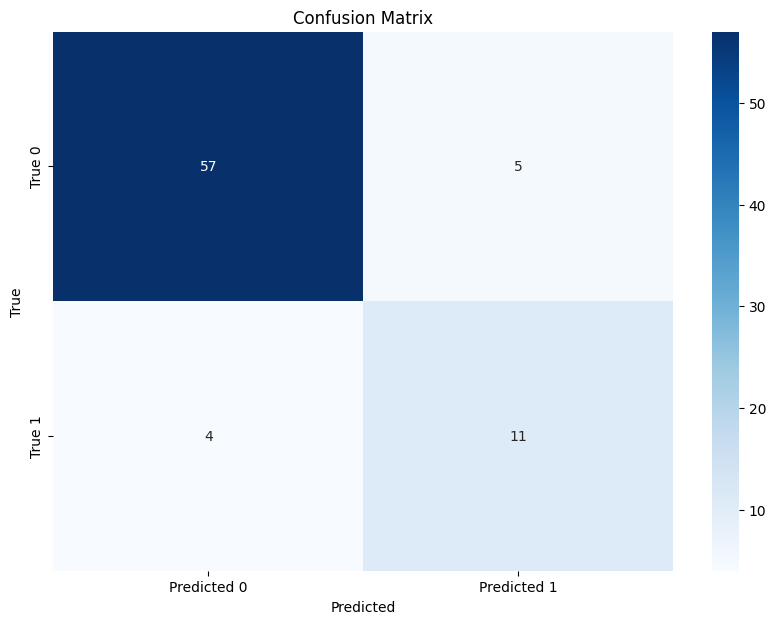

Learning Rate: 5e-05 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 3.1574, Val loss = 19.1238
Epoch 1: Train loss = 2.6686, Val loss = 20.4785
Epoch 2: Train loss = 2.3872, Val loss = 19.2688
Epoch 3: Train loss = 2.1409, Val loss = 14.9329
Epoch 4: Train loss = 2.0365, Val loss = 13.3429
Epoch 5: Train loss = 1.9304, Val loss = 11.4270
Epoch 6: Train loss = 1.8518, Val loss = 10.1605
Epoch 7: Train loss = 1.7329, Val loss = 9.6503
Epoch 8: Train loss = 1.6012, Val loss = 9.4700
Epoch 9: Train loss = 1.6148, Val loss = 9.6078
Epoch 10: Train loss = 1.5518, Val loss = 8.7392
Epoch 11: Train loss = 1.4788, Val loss = 10.4358
Epoch 12: Train loss = 1.5420, Val loss = 9.4346
Epoch 13: Train loss = 1.5697, Val loss = 7.9969
Epoch 14: Train loss = 1.2871, Val loss = 7.4072


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[60  2]
 [ 7  8]]


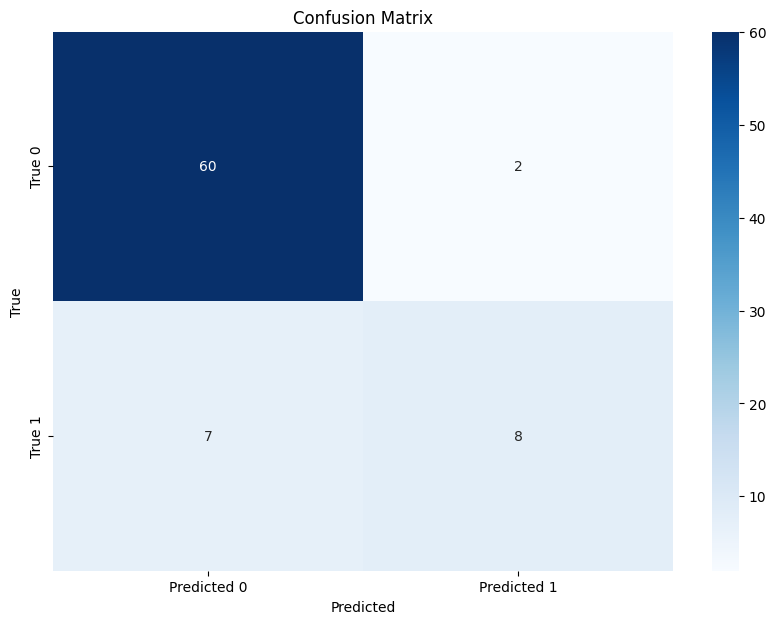

Learning Rate: 1e-05 - Validation Accuracy: 0.8831168831168831


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 3.2756, Val loss = 19.4989
Epoch 1: Train loss = 3.1518, Val loss = 18.9587
Epoch 2: Train loss = 3.1138, Val loss = 18.7930
Epoch 3: Train loss = 3.0703, Val loss = 19.3232
Epoch 4: Train loss = 2.9480, Val loss = 18.9481
Epoch 5: Train loss = 2.9500, Val loss = 19.6949
Epoch 6: Train loss = 2.9262, Val loss = 18.6732
Epoch 7: Train loss = 2.8401, Val loss = 19.6621
Epoch 8: Train loss = 2.8178, Val loss = 19.6448
Epoch 9: Train loss = 2.7518, Val loss = 18.5948
Epoch 10: Train loss = 2.7349, Val loss = 18.6533
Epoch 11: Train loss = 2.6620, Val loss = 18.5661
Epoch 12: Train loss = 2.6597, Val loss = 18.7283
Epoch 13: Train loss = 2.5989, Val loss = 18.1574
Epoch 14: Train loss = 2.5673, Val loss = 18.0342


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[18 44]
 [ 0 15]]


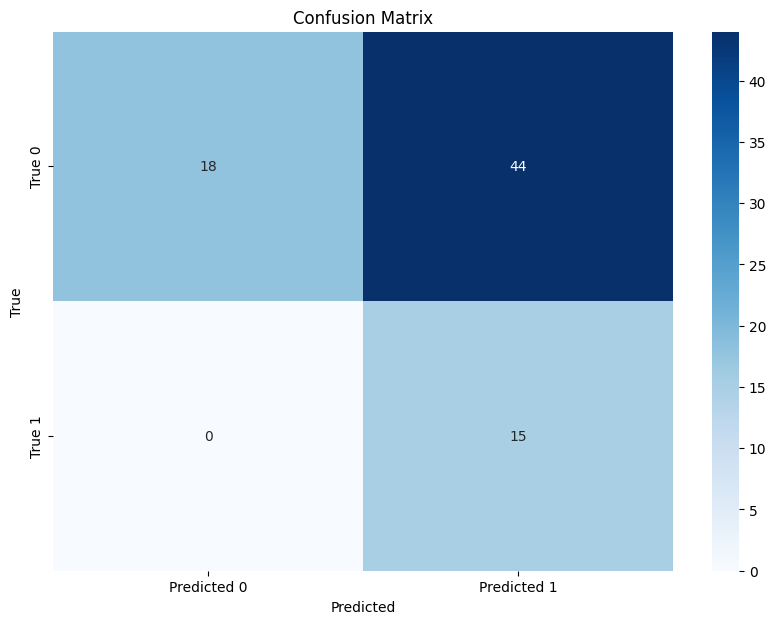

Learning Rate: 1e-06 - Validation Accuracy: 0.42857142857142855


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.4738, Val loss = 18.1133
Epoch 1: Train loss = 2.2354, Val loss = 18.7200
Epoch 2: Train loss = 2.1524, Val loss = 18.2802
Epoch 3: Train loss = 2.0988, Val loss = 16.7665
Epoch 4: Train loss = 2.0184, Val loss = 16.8634
Epoch 5: Train loss = 1.9508, Val loss = 17.1752
Epoch 6: Train loss = 1.9639, Val loss = 16.0292
Epoch 7: Train loss = 1.8162, Val loss = 15.2414
Epoch 8: Train loss = 1.7803, Val loss = 14.1834
Epoch 9: Train loss = 1.7990, Val loss = 12.4345
Epoch 10: Train loss = 1.7764, Val loss = 10.6994
Epoch 11: Train loss = 1.6235, Val loss = 11.8388
Epoch 12: Train loss = 1.7561, Val loss = 14.6810
Epoch 13: Train loss = 1.7138, Val loss = 16.7416
Epoch 14: Train loss = 1.6390, Val loss = 11.0724


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[53  9]
 [ 4 11]]


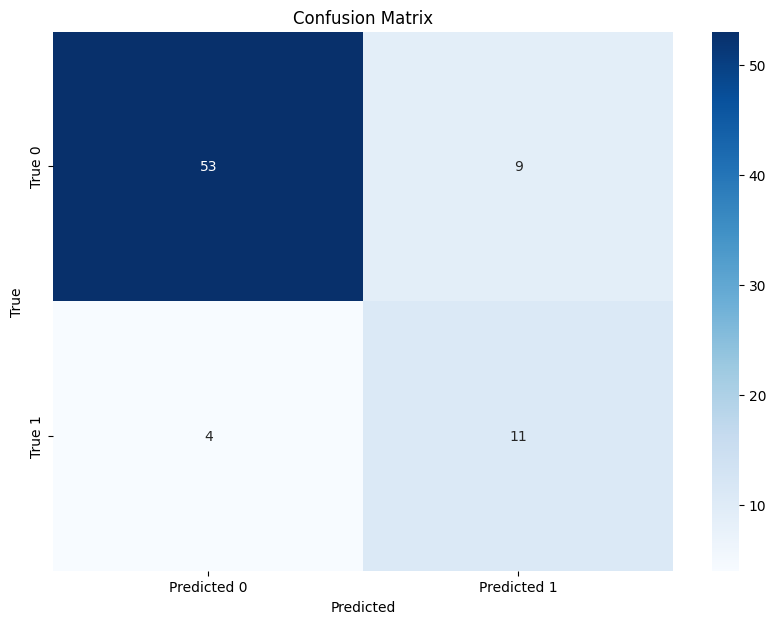

Learning Rate: 5e-06 - Validation Accuracy: 0.8311688311688312


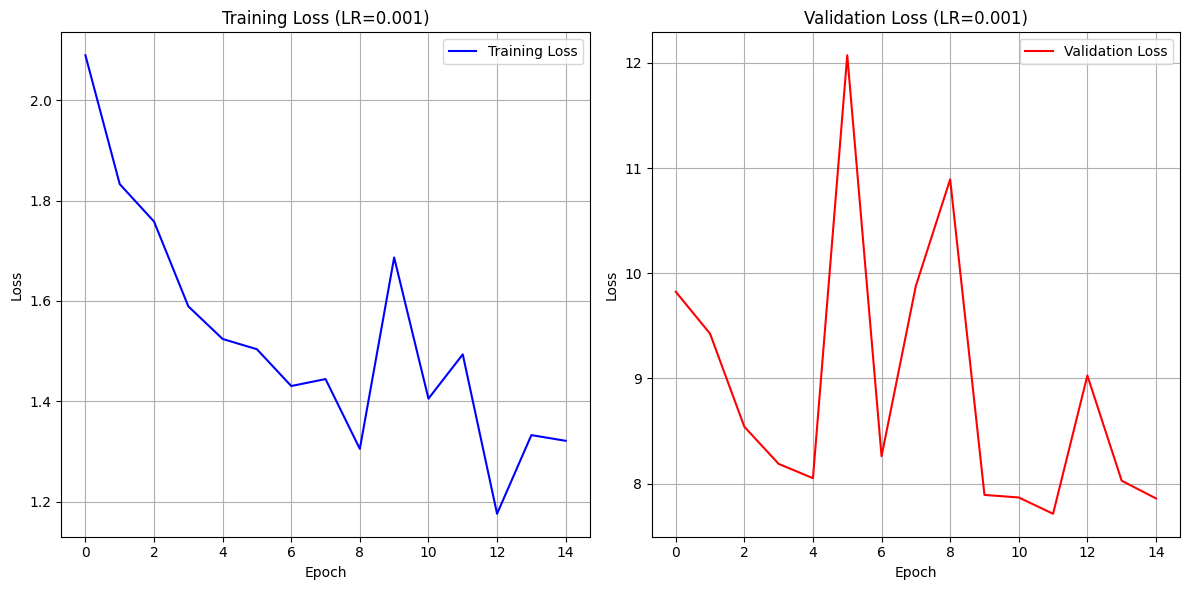

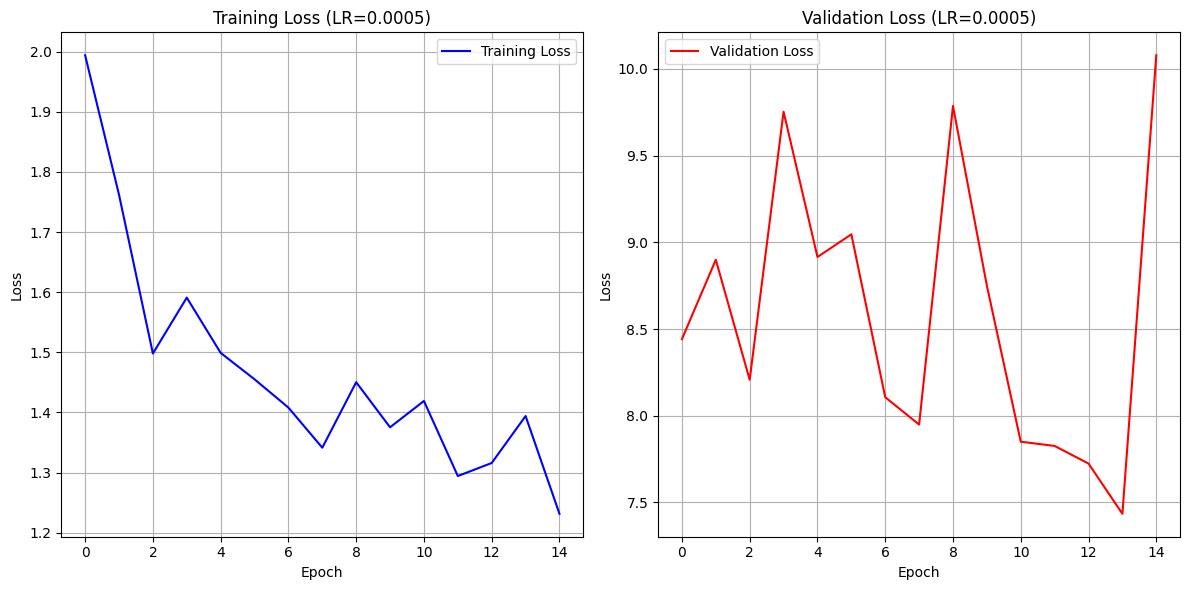

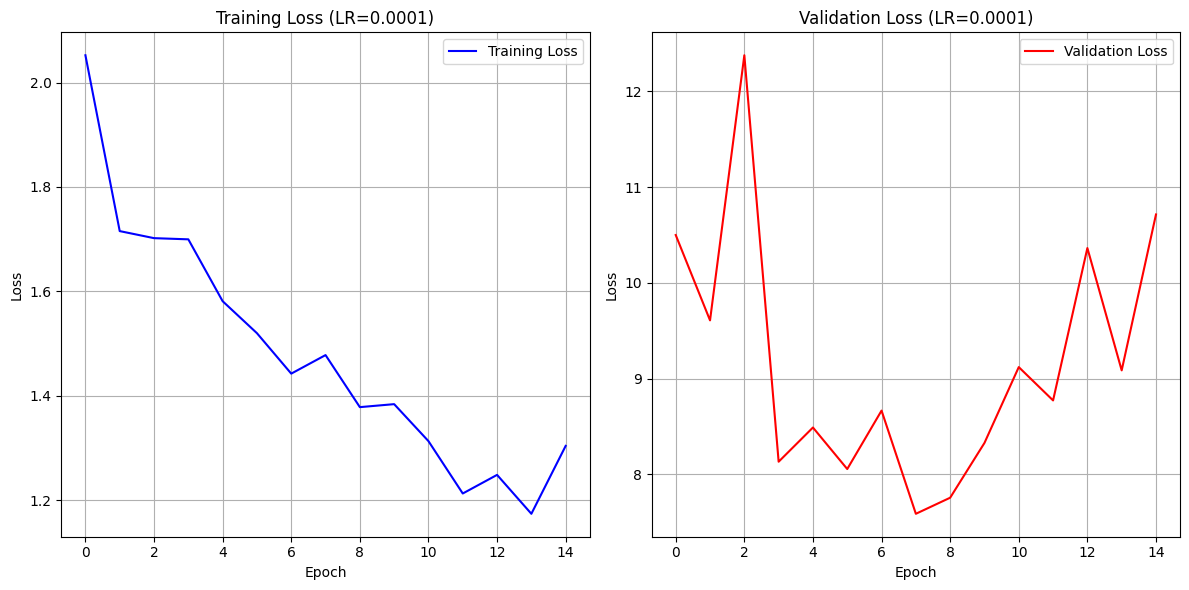

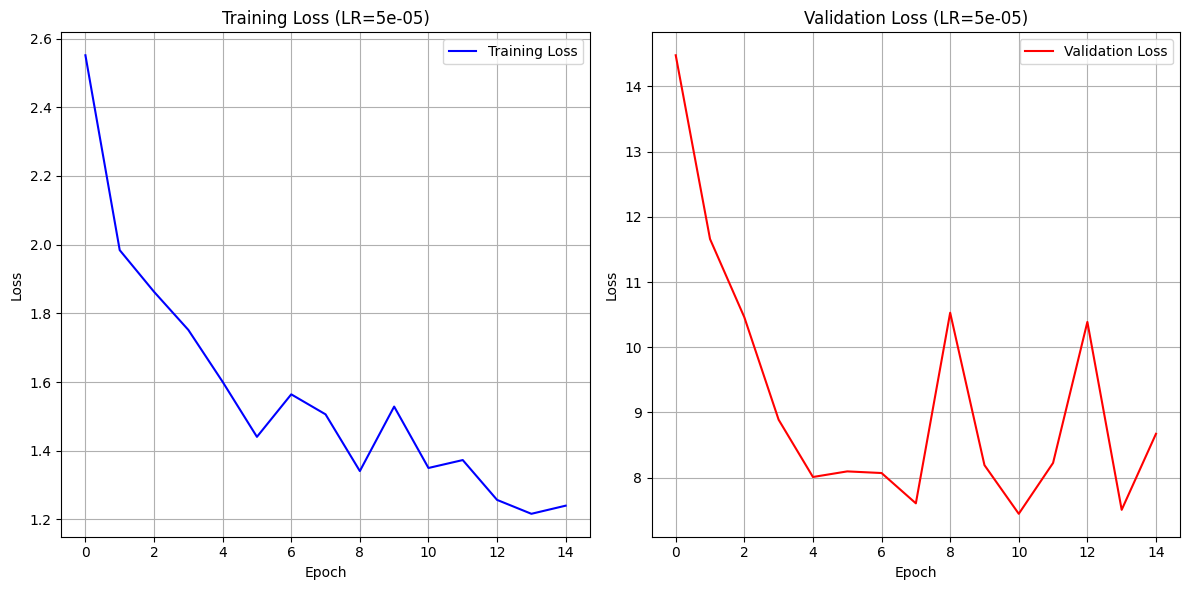

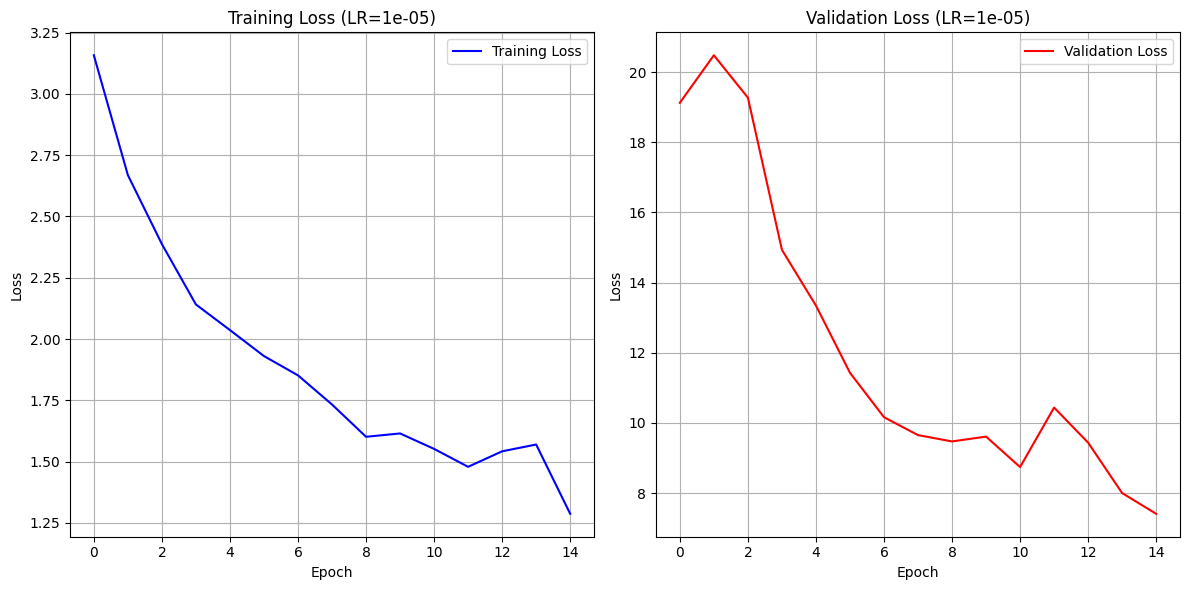

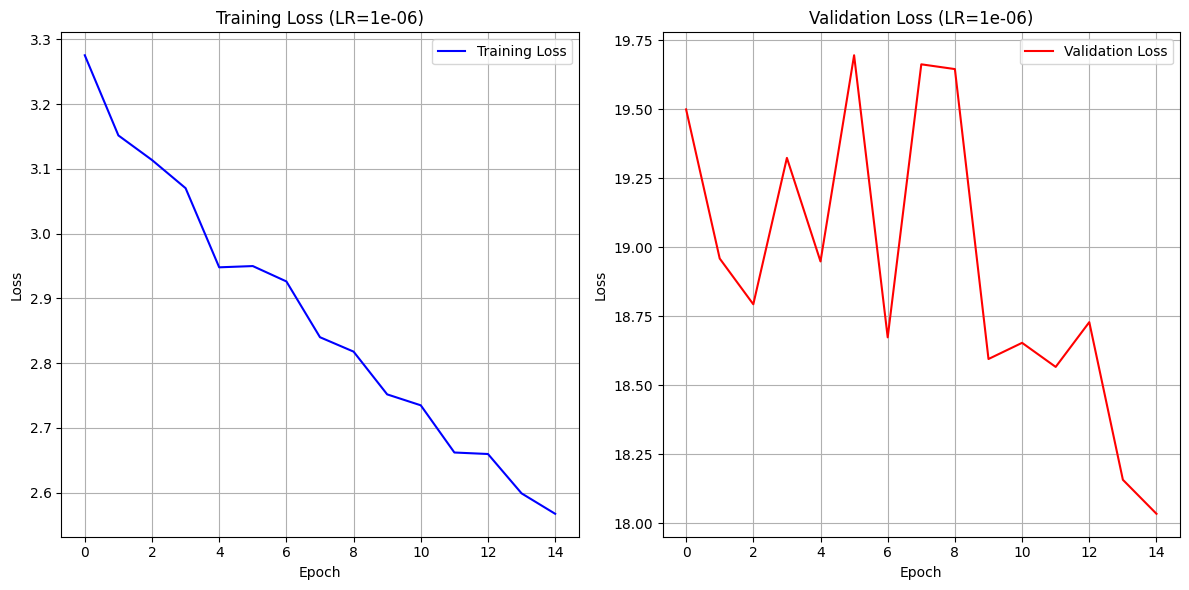

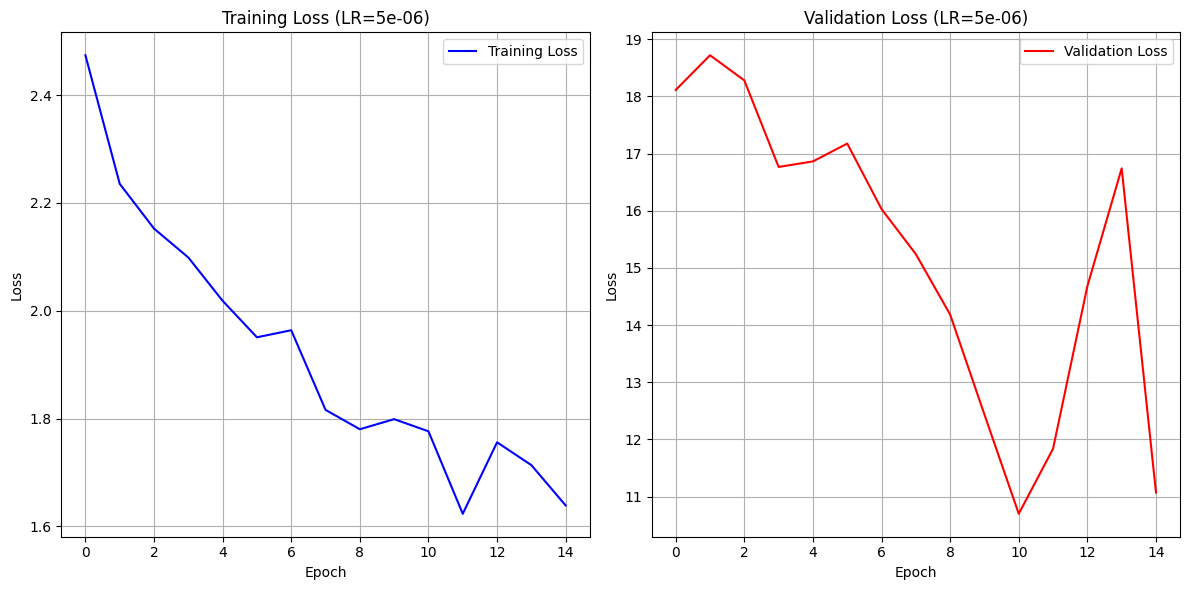

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6, 5e-6]
n_epochs = 15
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = DenseNet3D().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.4557, Val loss = 17.5025
Epoch 1: Train loss = 1.9413, Val loss = 12.1081
Epoch 2: Train loss = 1.7811, Val loss = 8.9745
Epoch 3: Train loss = 1.5889, Val loss = 11.5258
Epoch 4: Train loss = 1.6938, Val loss = 8.6105
Epoch 5: Train loss = 1.5293, Val loss = 11.9265
Epoch 6: Train loss = 1.6557, Val loss = 9.6092
Epoch 7: Train loss = 1.4344, Val loss = 8.2834
Epoch 8: Train loss = 1.5768, Val loss = 8.9384
Epoch 9: Train loss = 1.4669, Val loss = 8.1366
Epoch 10: Train loss = 1.5753, Val loss = 8.8205
Epoch 11: Train loss = 1.4164, Val loss = 8.7806
Epoch 12: Train loss = 1.5165, Val loss = 7.9652
Epoch 13: Train loss = 1.3391, Val loss = 11.0959
Epoch 14: Train loss = 1.4622, Val loss = 8.6224
Epoch 15: Train loss = 1.3871, Val loss = 8.9439
Epoch 16: Train loss = 1.3847, Val loss = 9.6247
Epoch 17: Train loss = 1.3035, Val loss = 10.5480
Epoch 18: Train loss = 1.4602, Val loss = 10.1820
Epoch 19: Train loss = 1.3878, Val loss = 9.6800
Epoch 20: Train loss = 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[53  9]
 [ 4 11]]


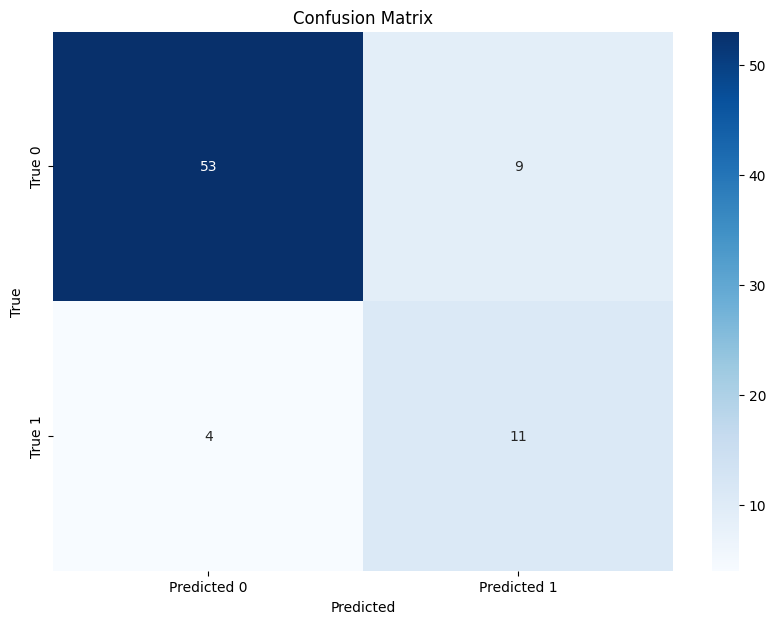

Learning Rate: 5e-05 - Validation Accuracy: 0.8311688311688312


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.0857, Val loss = 15.3614
Epoch 1: Train loss = 1.9991, Val loss = 13.0620
Epoch 2: Train loss = 1.9047, Val loss = 13.4501
Epoch 3: Train loss = 1.7536, Val loss = 9.4655
Epoch 4: Train loss = 1.7492, Val loss = 9.1892
Epoch 5: Train loss = 1.7500, Val loss = 8.5177
Epoch 6: Train loss = 1.6901, Val loss = 10.2099
Epoch 7: Train loss = 1.6677, Val loss = 7.8115
Epoch 8: Train loss = 1.5624, Val loss = 8.1083
Epoch 9: Train loss = 1.5003, Val loss = 8.8945
Epoch 10: Train loss = 1.4834, Val loss = 9.7471
Epoch 11: Train loss = 1.5894, Val loss = 9.2274
Epoch 12: Train loss = 1.5107, Val loss = 8.6492
Epoch 13: Train loss = 1.5180, Val loss = 8.0569
Epoch 14: Train loss = 1.4430, Val loss = 9.9736
Epoch 15: Train loss = 1.2986, Val loss = 8.4759
Epoch 16: Train loss = 1.4739, Val loss = 9.1303
Epoch 17: Train loss = 1.3915, Val loss = 9.2266
Epoch 18: Train loss = 1.3172, Val loss = 9.2457
Epoch 19: Train loss = 1.3718, Val loss = 9.2351
Epoch 20: Train loss = 1.3

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[55  7]
 [ 4 11]]


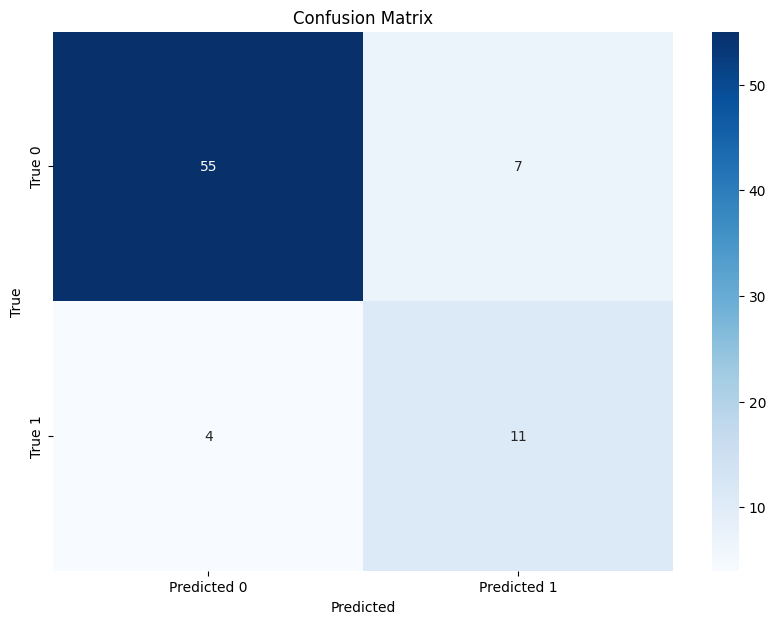

Learning Rate: 1e-05 - Validation Accuracy: 0.8571428571428571


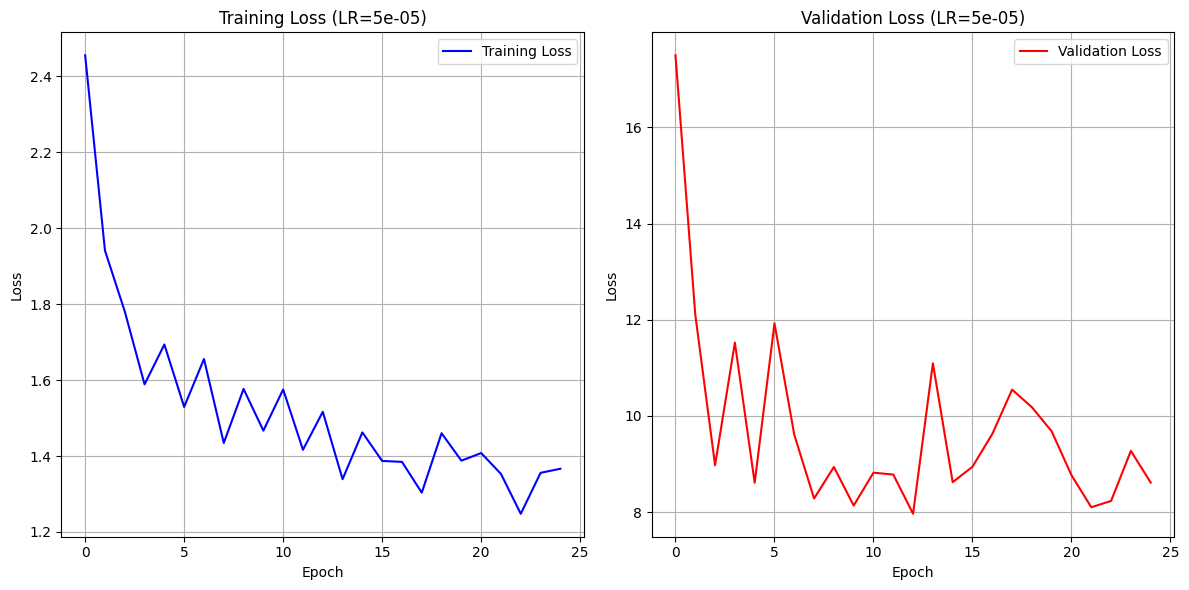

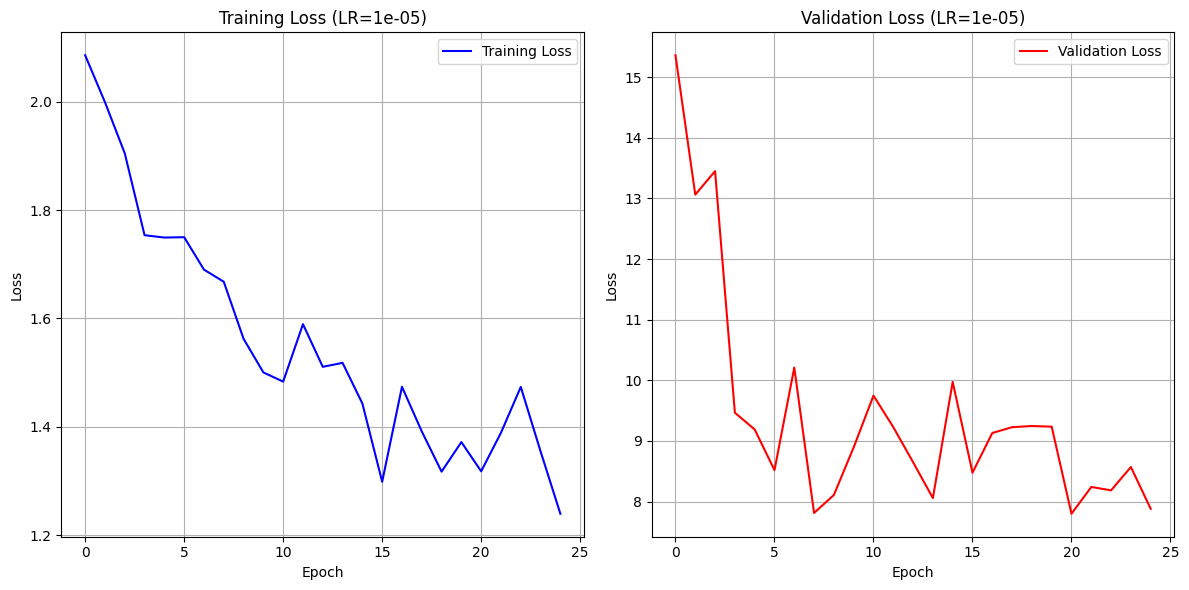

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [5e-5, 1e-5]
n_epochs = 25
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = DenseNet3D().cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)